# Analyzing customer service calls
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for conducting an analysis of textual content with AI agents and large language models. Using a set of transcripts of mock customer calls as an example, we use EDSL to prompt an AI agent to identify the callers' names, emails, questions and requests and return the results as a formatted dataset. The code is readily editable for reviewing other content, giving the agent different personas, and prompting the agent to extract other information.

## Technical setup
Before running the code below, please ensure that you have [installed the EDSL library](https://docs.expectedparrot.com/en/latest/installation.html) and either [activated remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) from your [Coop account](https://docs.expectedparrot.com/en/latest/coop.html) or [stored API keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for the language models that you want to use with EDSL. Please also see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started using EDSL.

## Constructing questions about the data
We start by constructing questions about the content we want to analyze. 
[EDSL comes with a variety of question types](https://docs.expectedparrot.com/en/latest/questions.html) that we can choose from based on the form of the response that we want to get back from the model (multiple choice, linear scale, free text, etc.). 
Here we use `QuestionFreeText` to get the caller names and emails and `QuestionList` to list out any questions and requests of the callers, with a `{{ placeholder }}` for a transcript:

In [1]:
from edsl import QuestionFreeText, QuestionList

# Construct questions in the relevant question type templates
# Use a placeholder for the transcripts to be reviewed
q_name = QuestionFreeText(
    question_name="name",
    question_text="""
    What is caller's name? Transcript: {{ scenario.transcript }}
    Return just the name of the caller.
    """,
)

q_email = QuestionFreeText(
    question_name="email",
    question_text="""What is caller's email address? Transcript: {{ scenario.transcript }}
    Return just the email address.
    """,
)

q_questions = QuestionList(
    question_name="questions",
    question_text="What questions does the caller have? Transcript: {{ scenario.transcript }}?",
)

q_requests = QuestionList(
    question_name="requests",
    question_text="What is the caller requesting? Transcript: {{ scenario.transcript }}?",
)

## Creating a survey
We combine the questions into a `Survey` in order to administer them all together:

In [2]:
from edsl import Survey

survey = Survey([q_name, q_email, q_questions, q_requests])

## Adding context to questions
Next we import a dataset of transcripts to add to the questions, creating a `Scenario` dictionary for each transcript. 
[EDSL provides methods for importing content from many different data sources](https://docs.expectedparrot.com/en/latest/scenarios.html), including PDFs, CSVs, docs, images, tables, lists, dicts, etc. 
Here we use a CSV of texts, [retrieved from the Coop](https://www.expectedparrot.com/content/01474c60-d02b-4874-a577-953e870d8bff):

In [3]:
from edsl import FileStore

csv_file = FileStore.pull('01474c60-d02b-4874-a577-953e870d8bff') 

In [4]:
from edsl import ScenarioList, Scenario

scenarios = ScenarioList.from_csv(csv_file.to_tempfile()) 

We can inspect the scenarios ([and rename or edit them as desired](https://docs.expectedparrot.com/en/latest/scenarios.html)):

In [5]:
scenarios

,transcript
0,"""Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I'm having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I'm sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you're using? Customer: I'm using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it's Emily Davis, emily.davis@example.com. Agent: Great, I'll send the instructions to your email. I'll update the software and try again. If it still crashes, I'll call back. Thanks for your help. Agent: You're welcome. Have a great day! [Caller sounded frustrated]"","
1,"""Agent: Good afternoon, Renovation Software Solutions. How may I help you? Customer: Hi, I'm looking for a tutorial on how to use the budget tracking feature. Is there a video or a guide available? Agent: Yes, we have several resources available. You can find tutorial videos and step-by-step guides on our website under the 'Support' section. If you need further assistance, we can also schedule a live demo with one of our specialists. Could I get your name and email address to send you the details? Customer: That sounds perfect. My name is Sarah Johnson, and my email is sarah.johnson@example.com. Agent: Thank you, Sarah. I'll send you the details shortly. Have a great day! Customer: Thank you! Agent: My pleasure. Have a great day! [Caller sounded satisfied]"","
2,"""Agent: Hello, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I need help with my account. I can't seem to reset my password, and I'm locked out. Agent: I'm sorry to hear that. Let's get that sorted out. Can you provide me with your email address associated with the account? Customer: Sure, it's mike.thomas@example.com. Agent: And may I have your name, please? Customer: Mike Thomas. Agent: Thank you, Mike. I'll send you a password reset link. Please check your email and follow the instructions. If you don't receive the email within a few minutes, check your spam folder or give us a call back. Customer: Got it. I'll keep an eye out for the email. Thanks for your help. Agent: You're welcome. Have a great day!"","
3,"""Agent: Good morning, Renovation Software Solutions. How may I help you today? Customer: Hi, I'm interested in upgrading my subscription plan. What are the options available? Agent: We offer several subscription plans to suit different needs. Our standard plan includes basic features, while our premium plan includes advanced tools and priority support. You can find detailed information on our website or I can email you a comparison chart. Customer: Please email me the comparison chart. My email is laura.miller@example.com. Agent: Certainly. Could I get your name as well? Customer: Laura Miller. Agent: Thank you, Laura. I'll send that over right away. If you have any questions after reviewing it, feel free to contact us. Customer: Will do. Thanks a lot! Agent: You're welcome. Have a great day!"","
4,"""Agent: Good afternoon, thank you for calling Renovation Software Solutions. How can I help you today? Customer: Hi, I'm having an issue with exporting my project to PDF. The file seems to be corrupted every time I try. Agent: I'm sorry to hear that. Can you tell me which version of the software you're using and the operating system? Customer: I'm using version 5.3.2 on macOS. Agent: Thank you. This issue can sometimes be resolved by updating to the latest version of the software. If the problem persists, please try reinstalling the software. If you continue to experience issues, o

## Designing an AI agent to answer the survey
We can create a persona for an AI `Agent` that a language model will use to answer the questions, and give it instructions on the task:

In [6]:
from edsl import Agent

agent = Agent(
    traits={"persona": "Customer service agent"},
    instruction="You are answering questions about transcripts of customer service calls.",
)

## Selecting a language model
We can select one or more specific models to generate the responses (if no model is specified the default model is used).

To see a list of all available models:

In [7]:
from edsl import Model

# Model.available()

To check the current default model:

In [8]:
Model()

,key,value
0,model,gpt-4o
1,parameters:temperature,0.500000
2,parameters:max_tokens,1000
3,parameters:top_p,1
4,parameters:frequency_penalty,0
5,parameters:presence_penalty,0
6,parameters:logprobs,False
7,parameters:top_logprobs,3
8,inference_service,openai


Here we select a model:

In [9]:
model = Model("gpt-4o")

## Getting responses
We generate responses by adding the scenarios, agent and model to the survey and then calling the `run()` method:

In [10]:
results = survey.by(scenarios).by(agent).by(model).run()

Job UUID,f18b8bfc-e9b4-42e2-9bce-10d40026d988
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/f18b8bfc-e9b4-42e2-9bce-10d40026d988
Exceptions Report URL,None
Results UUID,6cd9406b-08ab-4187-a6af-1f6fa6f7677b
Results URL,https://www.expectedparrot.com/content/6cd9406b-08ab-4187-a6af-1f6fa6f7677b


This generates a dataset of `Results` that we can begin analyzing. 
EDSL comes with [built-in methods for analyzing results](https://docs.expectedparrot.com/en/latest/results.html).
For example, we can print the responses in a table:

In [11]:
results.select("name", "email", "questions", "requests")

,answer.name,answer.email,answer.questions,answer.requests
0,Emily Davis,emily.davis@example.com,"[""I'm having trouble with the 3D rendering feature"", ""Which version of the software you're using?"", 'Could I have your name and email address to send you further instructions?']","['Help with 3D rendering feature crashing', 'Version update to resolve issue', 'Remote support session instructions']"
1,Sarah Johnson,sarah.johnson@example.com,['Is there a video or a guide available?'],"['tutorial on how to use the budget tracking feature', 'video or a guide']"
2,Mike Thomas,mike.thomas@example.com,"['I need help with my account', ""I can't seem to reset my password"", ""I'm locked out""]","['Help with account', 'Password reset', 'Locked out of account']"
3,Laura Miller,laura.miller@example.com,['What are the options available?'],"['upgrading subscription plan', 'email comparison chart']"
4,Jason Lee,jason.lee@example.com,"['How can I resolve the issue with exporting my project to PDF?', 'Which version of the software should I use?', ""What should I do if updating and reinstalling doesn't work?""]","['Issue with exporting project to PDF', 'Assistance with corrupted file', 'Follow-up from technical support']"
5,Olivia Brown,olivia.brown@example.com,"['Can multiple users work on the same project simultaneously?', 'How do I invite team members to my project?']","['If multiple users can work on the same project simultaneously', 'How to invite team members to a project']"
6,Kevin Turner,kevin.turner@example.com,"['How can I generate a cost estimate for my renovation project?', ""Why don't the numbers add up correctly?""]","['Generate a cost estimate for a renovation project', 'Assistance with automated cost estimation tool']"
7,Lisa Harris,lisa.harris@example.com,"[""I'm having trouble accessing my saved projects"", ""They don't appear in my account anymore""]",['Accessing saved projects']
8,Daniel Moore,daniel.moore@example.com,"[""Is there anything specific you'd like to see in this scheduling tool?""]","['a tool that helps with project scheduling and timelines', 'Gantt charts', 'reminders for key milestones']"
9,Amanda Clark,amanda.clark@example.com,['Questions about the trial period'],['Information about the trial period']


## Quantifying responses
We can use the lists of caller questions and requests to quantify them (how often do they appear in the calls?). We start by prompting an agent to synthesize the lists into comprehensive lists that we can use as question options for new questions:

In [12]:
caller_questions = results.select("questions").to_list(flatten=True)
len(caller_questions)

19

In [13]:
caller_requests = results.select("requests").to_list(flatten=True)
len(caller_requests)

22

In [14]:
q_condense = QuestionList(
    question_name="condense",
    question_text="""
    You have reviewed a set of call transcripts and compiled a detailed list of {{ scenario.topic }}. 
    Now you are being asked to condense this list into a more generalized but comprehensive 
    list that can be used to quanitfy the {{ scenario.topic }} efficiently (i.e., combine like items 
    on the list). Here is the list to be condensed: {{ scenario.list }}
    """,
    max_list_items=10,  # Optional
)

scenarios = ScenarioList([
    Scenario({"topic": "caller questions", "list": caller_questions}),
    Scenario({"topic": "caller requests", "list": caller_requests}),
])

condensed_lists = q_condense.by(scenarios).run()

Job UUID,eeff2d3b-9551-4ef7-bcc4-f3dfc765d907
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/eeff2d3b-9551-4ef7-bcc4-f3dfc765d907
Exceptions Report URL,None
Results UUID,287f32bb-6ca2-48a4-a9eb-5e6cdd0437eb
Results URL,https://www.expectedparrot.com/content/287f32bb-6ca2-48a4-a9eb-5e6cdd0437eb


In [15]:
condensed_lists.select("topic", "condense")

,scenario.topic,answer.condense
0,caller questions,"['Technical issues with software features', 'Version and update inquiries', 'Account access and password issues', 'Guides and instructional resources', 'Project collaboration and team management', 'Exporting and file management issues', 'Cost estimation and project calculations', 'Data access and retrieval issues', 'Feedback and feature requests', 'Trial period questions']"
1,caller requests,"['Technical support and troubleshooting', 'Account access and security', 'Subscription and billing inquiries', 'Feature usage tutorials and guides', 'Project collaboration and management', 'Software updates and version issues', 'Exporting and file handling', 'Automated tools and estimation', 'Trial period information', 'Remote support and follow-up']"


We can use the condensed lists as options for new questions quantifying the topics:

In [16]:
condensed_questions = (
    condensed_lists.filter("topic == 'caller questions'").select("condense").first()
)
condensed_questions

['Technical issues with software features',
 'Version and update inquiries',
 'Account access and password issues',
 'Guides and instructional resources',
 'Project collaboration and team management',
 'Exporting and file management issues',
 'Cost estimation and project calculations',
 'Data access and retrieval issues',
 'Feedback and feature requests',
 'Trial period questions']

In [17]:
condensed_requests = (
    condensed_lists.filter("topic == 'caller requests'").select("condense").first()
)
condensed_requests

['Technical support and troubleshooting',
 'Account access and security',
 'Subscription and billing inquiries',
 'Feature usage tutorials and guides',
 'Project collaboration and management',
 'Software updates and version issues',
 'Exporting and file handling',
 'Automated tools and estimation',
 'Trial period information',
 'Remote support and follow-up']

In [18]:
from edsl import QuestionCheckBox

q_questions_agg = QuestionCheckBox(
    question_name="questions_agg",
    question_text="""
    Review the following call transcript and then identify the topic(s)
    that the caller has questions about. Transcript: {{ scenario.transcript }}
    """,
    question_options=condensed_questions + ["Something else", "None of these"],
)

q_requests_agg = QuestionCheckBox(
    question_name="requests_agg",
    question_text="""
    Review the following call transcript and then identify the topic(s)
    that the caller has requests about. Transcript: {{ scenario.transcript }}
    """,
    question_options=condensed_requests + ["Something else", "None of these"],
)

survey = Survey([q_questions_agg, q_requests_agg])

We can use the results of the initial survey as scenarios of our follow-on questions. The `to_scenario_list()` method lets us do this in a single step:

In [19]:
scenarios = results.select("name", "email", "transcript").to_scenario_list(
    remove_prefix=True
)
scenarios[0]

,key,value
0,name,Emily Davis
1,email,emily.davis@example.com
2,transcript,"""Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I'm having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I'm sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you're using? Customer: I'm using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it's Emily Davis, emily.davis@example.com. Agent: Great, I'll send the instructions to your email. I'll update the software and try again. If it still crashes, I'll call back. Thanks for your help. Agent: You're welcome. Have a great day! [Caller sounded frustrated]"","


In [20]:
agg_results = survey.by(scenarios).by(agent).run()

Job UUID,993b0967-7b65-4019-93cc-dedf46716636
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/993b0967-7b65-4019-93cc-dedf46716636
Exceptions Report URL,None
Results UUID,344831cd-7a6e-4952-b4ca-9bfd6c141024
Results URL,https://www.expectedparrot.com/content/344831cd-7a6e-4952-b4ca-9bfd6c141024


In [21]:
agg_results.columns

,0
0,agent.agent_index
1,agent.agent_instruction
2,agent.agent_name
3,agent.persona
4,answer.questions_agg
5,answer.requests_agg
6,cache_keys.questions_agg_cache_key
7,cache_keys.requests_agg_cache_key
8,cache_used.questions_agg_cache_used
9,cache_used.requests_agg_cache_used


In [22]:
agg_results.select("questions_agg", "requests_agg")

,answer.questions_agg,answer.requests_agg
0,"['Technical issues with software features', 'Version and update inquiries']","['Technical support and troubleshooting', 'Software updates and version issues', 'Remote support and follow-up']"
1,['Guides and instructional resources'],['Feature usage tutorials and guides']
2,['Account access and password issues'],['Account access and security']
3,['Something else'],['Subscription and billing inquiries']
4,"['Technical issues with software features', 'Version and update inquiries', 'Exporting and file management issues']","['Technical support and troubleshooting', 'Software updates and version issues', 'Exporting and file handling']"
5,"['Project collaboration and team management', 'Guides and instructional resources']","['Feature usage tutorials and guides', 'Project collaboration and management']"
6,"['Technical issues with software features', 'Cost estimation and project calculations']","['Technical support and troubleshooting', 'Automated tools and estimation', 'Remote support and follow-up']"
7,"['Technical issues with software features', 'Data access and retrieval issues']","['Technical support and troubleshooting', 'Account access and security']"
8,['Feedback and feature requests'],['Something else']
9,['Trial period questions'],['Trial period information']


## Visualizations
We can turn the results into a dataframe and inspect the totals:

In [23]:
import matplotlib.pyplot as plt
import ast

In [24]:
df = agg_results.to_pandas(remove_prefix=True)

In [25]:
# Convert the string representations of lists to actual lists
df["questions_agg"] = df["questions_agg"].apply(ast.literal_eval)
df["requests_agg"] = df["requests_agg"].apply(ast.literal_eval)

# Explode the lists into individual rows
questions_exploded = df.explode("questions_agg")
requests_exploded = df.explode("requests_agg")

# Count the frequency of each item
questions_counts = questions_exploded["questions_agg"].value_counts().reset_index()
questions_counts.columns = ["Question", "Count"]

requests_counts = requests_exploded["requests_agg"].value_counts().reset_index()
requests_counts.columns = ["Request", "Count"]

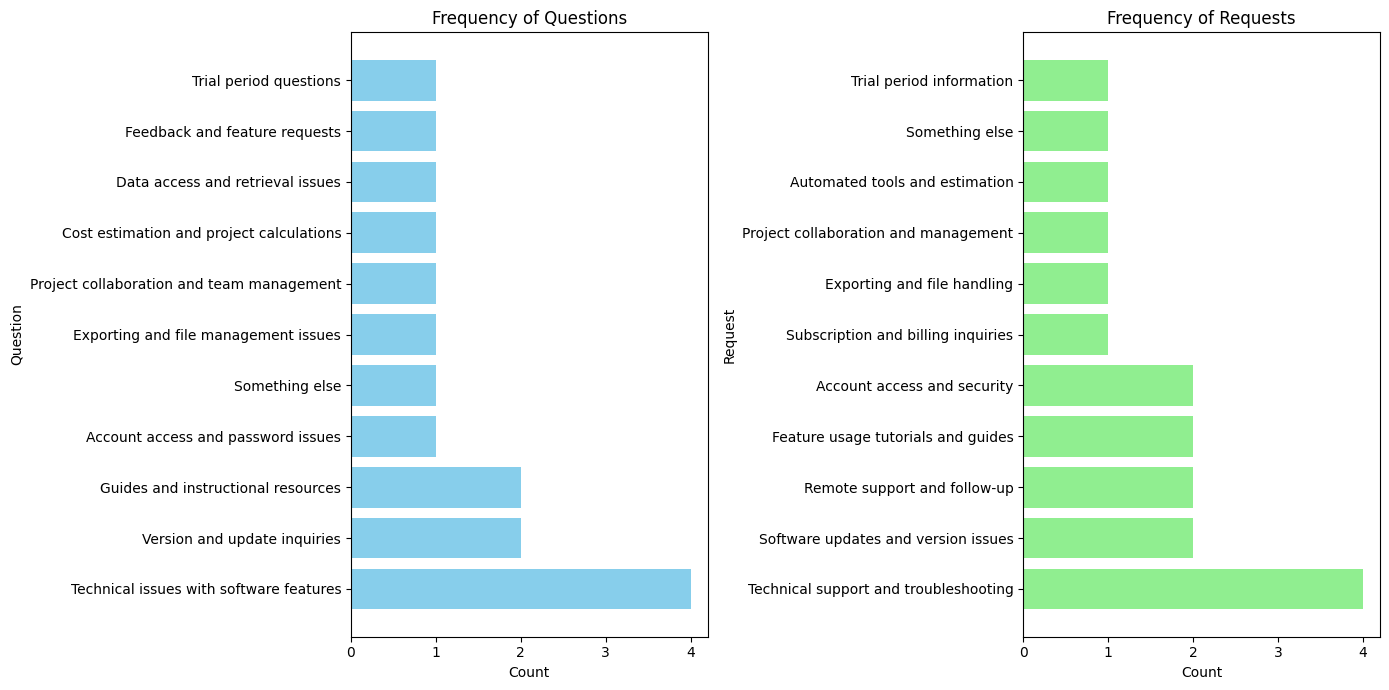

In [26]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Bar plot for questions
axes[0].barh(questions_counts["Question"], questions_counts["Count"], color="skyblue")
axes[0].set_title("Frequency of Questions")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Question")

# Bar plot for requests
axes[1].barh(requests_counts["Request"], requests_counts["Count"], color="lightgreen")
axes[1].set_title("Frequency of Requests")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Request")

plt.tight_layout()
plt.show()

In [27]:
# Display the counts
print("Questions Count Table:")
print(questions_counts)

print("\nRequests Count Table:")
print(requests_counts)

Questions Count Table:
                                     Question  Count
0     Technical issues with software features      4
1                Version and update inquiries      2
2          Guides and instructional resources      2
3          Account access and password issues      1
4                              Something else      1
5        Exporting and file management issues      1
6   Project collaboration and team management      1
7    Cost estimation and project calculations      1
8            Data access and retrieval issues      1
9               Feedback and feature requests      1
10                     Trial period questions      1

Requests Count Table:
                                  Request  Count
0   Technical support and troubleshooting      4
1     Software updates and version issues      2
2            Remote support and follow-up      2
3      Feature usage tutorials and guides      2
4             Account access and security      2
5      Subscription and 

## Exporting results
We can export the results as a CSV:

In [28]:
agg_results.to_csv("customer_calls_analysis.csv")

File written to customer_calls_analysis.csv


Please see our [documentation page](https://docs.expectedparrot.com/) for examples of other methods and use cases!

## Posting content to the Coop

In [ ]:
from edsl import Notebook

nb = Notebook(path = "summarizing_transcripts.ipynb")

if refresh := False:
    nb.push(
        description = "Example code for summarizing transcripts", 
        alias = "summarizing-transcripts-notebook",
        visibility = "public"
    )
else:
    nb.patch("https://www.expectedparrot.com/content/RobinHorton/summarizing-transcripts-notebook", value = nb)